<a href="https://colab.research.google.com/github/kaxlenoa/nebius-llm-essentials/blob/main/topic1/1.1_intro_to_llm_apis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)
# 1.1. Intro to LLM APIs

In this notebook, we'll start exploring LLMs and LLM APIs, their capabilities and their failures. After working with it, you'll be able to call APIs of LLMs and Multimodal LLMs such as GPT-4o, Llama-3.1-8B, Qwen2-VL-72B, and many more.

# The first step: getting API keys

Mostly we'll use the API of **Nebius AI Studio** (https://studio.nebius.ai/): This platform offers open-source LLMs from families such as Llama, Mistral, Qwen, and Gemma. Generate your API key here: [Nebius API Keys](https://studio.nebius.ai/settings/api-keys) (this page will only be available after you register).

However, in some examples we'll also check **OpenAI** API (https://platform.openai.com/), which provides access to GPT models like GPT-4. You can generate an API key here: [OpenAI API Keys](https://platform.openai.com/settings/organization/api-keys) (this page will only be available after you register).

An API key is just a string (usually, a long one). Each platform will only show you your API key once when it’s generated, so be sure to copy it and save it securely. If you lose your API key, you'll be able to generate a new one (but in this case, don't forget to invalidate the old one on a platform).
To set up for the class, please

* Save the Nebius API key in a file named `nebius_api_key` (also no file extension).
* Save the OpenAI API key in a file named `openai_api_key` (no file extension).
* Then load them both to colab.

We aim to explore close-to-production use of LLMs, so we start with APIs, but of course every LLM has its own playground:

- Nebius AI Studio's playground is here: https://studio.nebius.ai/playground.
- Feel free to play with OpenAI models here: https://chatgpt.com/.

# **Setting up the environment**

Let's install the `openai` library (the `-q` flag saves us from reading the outputs) and get the API keys.

In [12]:
!pip install -q openai

You'll need to upload the API keys to your current Jupyter directory. If you're running Jupyter on your own Linux machine, you can check which directory it is by running `!pwd`

In [13]:
import os

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

# **Trying Nebius AI Studio and OpenAI**

## Nebius API

Nebius AI Studio serves several families of open source LLMs, including: Llama, Qwen, DeepSeek, Gemma, Mistral, Phi, and others.


### The client and the model

First of all, you need to define:

* **client**, which in case of Nebius AI Studio is

  ```
  client = OpenAI(
      base_url="https://api.studio.nebius.ai/v1/",
      api_key=os.environ.get("NEBIUS_API_KEY"),
  )
  ```

* **model**, that is the particular LLM we want to use. You can find more details about models, their pricing and other parameters [here](https://studio.nebius.ai/models).

  To get the right model name for the API call, press the small "copy" button at the top right corner of a model card:

  <center>
  <img src="https://drive.google.com/uc?export=view&id=1w9IkQ4hmwqFqYbLiXlu0iNIfm2l7Vrem" width=1000 />
  </center>

  For example, **Llama-3.3-70B** should be called using `model = "meta-llama/Llama-3.3-70B-Instruct"`.

### Prompt and completion

The text passed to an LLM is usually called a **prompt** and the LLM's output is known as **completion** (or response).

Let's make a simple API call to illustrate this:

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            # This is the prompt:
            "content": """The following Python implementation of the QuickSort algorithm contains a bug.
                          Find the bug and correct the code:
                          def quicksort(arr):
                              if len(arr) <= 1:
                                  return arr
                              pivot = arr[0]
                              left = [x for x in arr if x < pivot]
                              right = [x for x in arr if x >= pivot]
                              return quicksort(left) + [pivot] + quicksort(right)
                          """},
    ]
)

The `completion` variable contains much information; to extract only the completion. The answer itself is `completion.choices[0].message.content`:

In [ ]:
print(completion.choices[0].message.content)

**Bug Analysis**

The bug in the provided QuickSort implementation is in the line where the `right` list is generated. Currently, the code includes the pivot element in the `right` list, which is incorrect. The pivot element should be excluded from both the `left` and `right` lists.

**Corrected Code**

Here is the corrected implementation:

```python
def quicksort(arr):
    """
    Sorts an array using the QuickSort algorithm.

    Args:
        arr (list): The input array to be sorted.

    Returns:
        list: The sorted array.
    """
    if len(arr) <= 1:
        return arr
    pivot = arr[0]
    left = [x for x in arr[1:] if x < pivot]  # exclude pivot and start from index 1
    right = [x for x in arr[1:] if x >= pivot]  # exclude pivot and start from index 1
    return quicksort(left) + [pivot] + quicksort(right)
```

**Explanation**
---------------

In the corrected code, we use list slicing (`arr[1:]`) to exclude the pivot element from both the `left` and `right` lists. Thi

The `"usage"` dictionary stores token statistics that can be used to estimate the generation cost. You can check LLM pricing details in their model cards. As for February 18th, 2025, for the **Llama-3.1-8B** model you'd pay:

* \$0.13 / 1M (million) input (prompt) tokens,
* \$0.5 / 1M output (completion) tokens.

Let's calculate the price for our example:

In [ ]:
(completion.usage.prompt_tokens * 0.13 + completion.usage.completion_tokens * 0.5) / (10**6)

0.00024613

Which is way less than 1 cent.

The prompt and completion length are indicated in **tokens**, which are usually word pieces. We'll discuss tokenization later this week.

### Dialog roles

The `messages` object you pass to the LLM API is a dictionary with fields `"content"` and `"role"`. Roles may be:

- `"user"`, that's you.
- `"assistant"`, a model's cue.
- `"system"` used to pass our wishes regarding the assistant's tone of voice, restrictions etc.

So, a dialog between a user and an LLM may look like:

```
messages=[
        {
            "role": "system",
            "content": <system prompt>
        },
        {
            "role": "user",
            "content": <user's first line>
        },
        {
            "role": "assistant"
            "content": <LLM's answer>
        },
        {
            "role": "user"
            "content": <user's second line>
        }
    ]
```

Let's look at an example:

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant."
        },
        {
            "role": "user",
            "content": """Who's a cooler fantasy writer: J. R. R. Tolkien or George R. R. Martin.?"""
        },
]

completion = client.chat.completions.create(
    model=model,
    messages=messages
)
completion.choices[0].message.content

'While both J.R.R. Tolkien and George R.R. Martin are incredible fantasy writers, I\'ll try to break it down and help you decide who\'s cooler (keep in mind this is subjective!).\n\n**Tolkien:**\n\n* Created Middle-earth, a sprawling, meticulously detailed world that\'s become the gold standard for fantasy world-building.\n* Wrote "The Hobbit" and "The Lord of the Rings" trilogy, which has captivated readers for generations and inspired countless adaptations.\n* Developed Elvish languages, which have been studied and attempted to be spoken by fans worldwide.\n* Laid the groundwork for modern fantasy literature, influencing countless authors and creators.\n\nCool factor: 9/10 ( Academic, world-builder extraordinaire, and cute British accent)\n\n**George R.R. Martin:**\n\n* Crafted Westeros and the world of A Song of Ice and Fire, featuring morally complex characters, epic battles, and shocking plot twists.\n* Broke the mold of traditional fantasy storytelling with his gritty, realistic 

We may continue dialog by appending the LLM's answer as an **assistant** message to the `messages` list and then adding the user's next question:

In [ ]:
# We add the assistant's message
messages.append(
    {
        "role": "assistant",
        "content": completion.choices[0].message.content
    }
)

# Now, let's continue the dialog
messages.append(
    {
        "role": "user",
        "content": "But which one do you prefer? Choose only one of them!"
    }
)

completion = client.chat.completions.create(
    model=model,
    messages=messages
)
completion.choices[0].message.content

'I see what you\'re doing here! As a helpful assistant, I don\'t have personal preferences or opinions, but I can tell you which author is more... computationally fascinating.\n\nIf I had to "prefer" one (just for the sake of argument!), I\'d say... George R.R. Martin!\n\nHere\'s why:\n\n1. **Complexity**: Martin\'s world-building is incredibly intricate, with a vast array of characters, plotlines, and politics. His series, A Song of Ice and Fire, is a treasure trove of storytelling complexity.\n2. **Characters**: Martin\'s characters are multidimensional, flawed, and often likable despite (or because of) their flaws. He\'s expertly built a vast cast of relatable characters that captivate readers.\n3. **Innovative storytelling**: Martin\'s decision to subvert traditional fantasy tropes and conventions has inspired a new wave of writers. His approach is refreshing, exciting, and often unpredictable.\n4. **Prolific output**: Although the wait between books can be... hair-raising, Martin\

This way, you may keep quite long conversations in an LLM's "memory". But this memory isn't infinite; at some point you may hit the max context length.

**Note**. Structuring dialog as a list of messages is a good LLM engineering practice, but under the hood, all these messages are concatenated into something like this (the exact format depends on the LLM)

```
#SYSTEM
<system message>

#USER
<user's line 1>

#ASSISTANT
<assistant's line 1>

#USER
<user's line 2>
```

to be sent to the LLM as one structured prompt.

### Max context length

Each LLM has **max context length**, which is the maximal sum of lengths of all messages the LLM is going to process. For Llama-3.1 models it's 128k tokens. After you hit max context length, some of the starting messages will be ignored.

A short reference for you about the lengths of various data (with the tokenizer of Llama-3-8B; see details below; the numbers for other models' tokenizers would be close to that).

| Text  | n_tokens  |
|----------|----------|
| [Text2text\_generation.py from Transformers](https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/text2text_generation.py)   | 3.5k   |
| [xLSTM paper .tex file](https://arxiv.org/abs/2405.04517)    | 39k  |
| Harry Potter and the Philosopher's Stone | 109K |
| [UK Energy Act 2023](https://www.legislation.gov.uk/ukpga/2023/52/contents)   | 248k   |
| Lord of the Rings | 500K |
| Langchain github repo | 5.2M |
| Pytorch github repo | 28M |

And here are max context lengths of some of the popular LLMs:

| LLM  | max_tokens  |
|----------|----------|
| gpt-4o(-mini)   | 128k   |
| Claude 3.5 (Haiku & Sonnet)    | 200k  |
| Gemini 2.0 Flash | 1M |
| Llama 3.1   | 128k   |
| Qwen 2.5 | 128K |

These numbers are actually quite generous, and you'll be more than ok with them in most applications, but, as you see, some documents or document collections just can't be process by an LLM in one call.

## The max_tokens parameter

The API has many parameters which we'll be exploring in details in these notebooks. Let's start with `max_tokens`. It allows to control how many tokens will the **prompt + completion** have.

Let's look at an example:

In [ ]:
from openai import OpenAI

# Nebius uses the same OpenAI() class, but with additional details
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Which LLM to use
# For more models, see https://studio.nebius.ai/models
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"
completion = client.chat.completions.create(
    model=model,
    messages=[
    {
        "role": "system",
        "content": """You're a helpful assistant."""
    },
    {
        "role": "user",
        "content": """Explain in details the plot of Silmarillion."""
    },
    ],
    max_tokens=52
)

print(completion.to_json())

{
  "id": "chatcmpl-13a1c35d09e9483b9ca6deae88fda3fd",
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "What an epic task you've assigned me!\n\nThe Silmarillion is a high fantasy novel by J.R.R. Tolkien, aitution to Middle-earth's history, published posthumously in 1977. It's a complex, sprawling narrative that explores the",
        "refusal": null,
        "role": "assistant",
        "audio": null,
        "function_call": null,
        "tool_calls": [],
        "reasoning_content": null
      },
      "stop_reason": null
    }
  ],
  "created": 1746654115,
  "model": "meta-llama/Meta-Llama-3.1-70B-Instruct",
  "object": "chat.completion",
  "service_tier": null,
  "system_fingerprint": null,
  "usage": {
    "completion_tokens": 52,
    "prompt_tokens": 32,
    "total_tokens": 84,
    "completion_tokens_details": null,
    "prompt_tokens_details": null
  },
  "prompt_logprobs": null
}


Note that `"finishing_reason"` is now `"length"` (instead of `"stop"`, which would mean normal termination). This means that generation was stopped when it hit `max_length`.

Let's also extract the answer itself:

In [ ]:
print(completion.choices[0].message.content)

What an epic task you've assigned me!

The Silmarillion is a high fantasy novel by J.R.R. Tolkien, aitution to Middle-earth's history, published posthumously in 1977. It's a complex, sprawling narrative that explores the


As you see, it's far from being a detailed description of the plot.

## OpenAI API

In this notebook we'll also try OpenAI API.

Its **client** is just `OpenAI()`. You can check the OpenAI's [model reference page](https://platform.openai.com/docs/models) to see what choice of the **models** they have. At the moment, we'd suggest choosing between:

* **gpt-4o-mini**, which is cheap, fast, and overall quite powerful,
* **gpt-4o**, which is larger, more capable, and more expensive, but not terribly so.

Let's make a simple API call:

In [ ]:
from openai import OpenAI

client = OpenAI()
# Choosing which LLM to call
# More models here: https://platform.openai.com/docs/models
model = "gpt-4o-mini"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            "content": """Who is the author of the Dune series?"""},
    ]
)
completion.choices[0].message.content

'The author of the original Dune series is Frank Herbert. He wrote the first novel, "Dune," which was published in 1965. The series consists of six books written by Herbert. After his death, his son, Brian Herbert, along with co-author Kevin J. Anderson, continued the series with prequels and sequels based on Frank Herbert\'s notes.'

The API's interface is just the same.

# Multimodal input

Modern LLMs also increasingly incorporate other modalities, usually Images. LLMs that have such capabilities are called **VLM**s (Visual Language Models) or, more generally **MLLM**s (**Multimodal LLMs**).

Let's see how this works. For that, we'll load a synthetically generated map and ask **gpt-4o-mini** to find a route between two of its regions.

In [ ]:
!gdown 1OW4MjT6A-5gUpyAi0_NyH94tCoNKGu8p

Downloading...
From: https://drive.google.com/uc?id=1OW4MjT6A-5gUpyAi0_NyH94tCoNKGu8p
To: /content/map000.png
100% 190k/190k [00:00<00:00, 76.4MB/s]


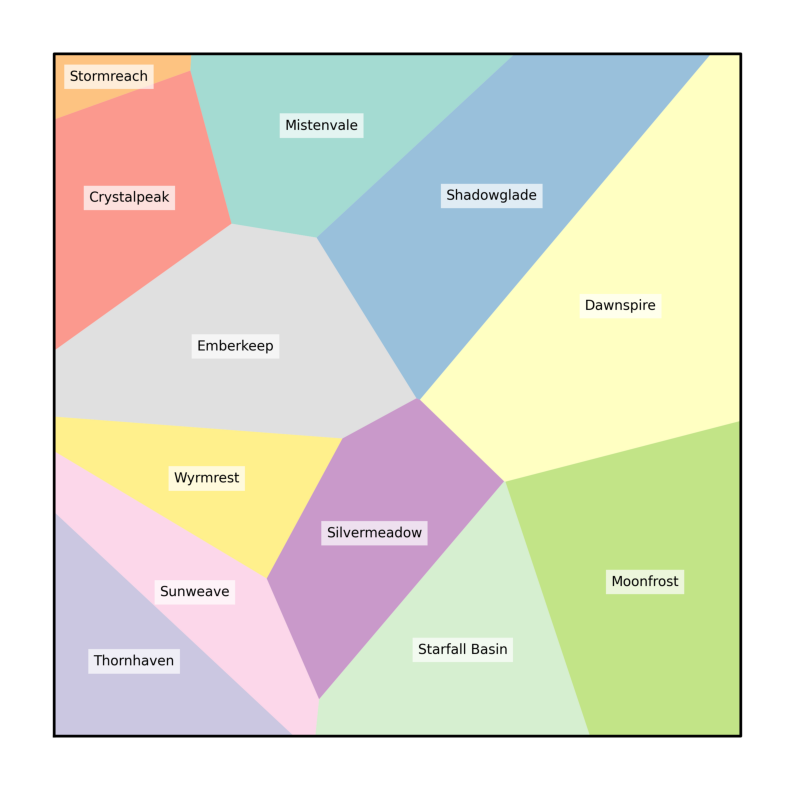

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('map000.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

OpenAI API requires to encode an image with `base64` before sending it to an LLM:

In [ ]:
from openai import OpenAI
import base64

IMAGE_PATH = 'map000.png'
model = 'gpt-4o-mini'
client = OpenAI()

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

journey_start = "Sunweave"
journey_end = "Shadowglade"

geography_prompt = f"""You are given a map of a fantasy realm.
It is divided into a number of regions with the name of the region indicated inside of it.
Your task is to describe potential journey from {journey_start} to {journey_end}.
Make sure that consecutive regions in the journey plan are really adjacent.
Only output a list of regions you'd pass on this journey as a list in exactly the following format:

JOURNEY:

{journey_start}
Region_1
...
Region_n
{journey_end}

YOUR RESPONSE:"""

completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are an expert pathfinder"},
        {"role": "user", "content": [
            {"type": "text", "text": geography_prompt},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ]
)

print(completion.choices[0].message.content)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## Multimodality with Nebius API

Nebius AI Studio also serves a number of VLMs, which can be assessed [here](https://studio.nebius.ai/models/vision). As before, the interface stays the same; you just need to choose the right client and an appropriate model. We'll use **Qwen2-VL-72B**.

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)


IMAGE_PATH = 'map000.png'

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)



journey_start = "Sunweave"
journey_end = "Shadowglade"


geography_prompt = f"""You are given a map of a fantasy realm.
It is divided into a number of regions with the name of the region indicated inside of it.
Your task is to describe potential journey from {journey_start} to {journey_end}.
Make sure that consecutive regions in the journey plan are really adjacent.
Only output a list of regions you'd pass on this journey as a list in exactly the following format:

JOURNEY:

{journey_start}
Region_1
...
Region_n
{journey_end}

YOUR RESPONSE:"""

model = "Qwen/Qwen2-VL-72B-Instruct"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are an expert pathfinder"},
        {"role": "user", "content": [
            {"type": "text", "text": geography_prompt},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ]
)

print(completion.choices[0].message.content)

JOURNEY:

Sunweave
Silvermeadow
Shadowglade


# Generating images with Nebius AI Studio

Nebius AI Studio also serves several text-to-image models such as **Flux** by **Black Forest Labs**. Let's try it:

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)


response = client.images.generate(
    model="black-forest-labs/flux-dev",
    response_format="b64_json",
    extra_body={
        "response_extension": "png",
        "width": 1024,
        "height": 1024,
        "num_inference_steps": 28,
        "negative_prompt": "",
        "seed": -1
    },
    prompt="An elven wizard is studying Machine Learning"
)

response_json = response.to_json()

Let's now plot the image:

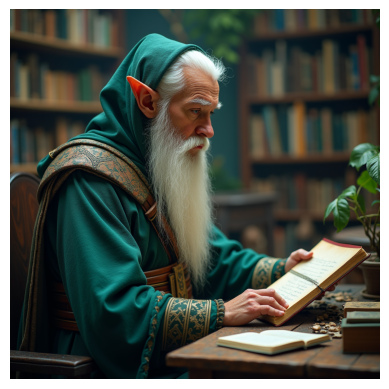

In [ ]:
import matplotlib.pyplot as plt
import base64
import json
from PIL import Image
from io import BytesIO


response_data = json.loads(response_json)
b64_image = response_data['data'][0]['b64_json']
image_bytes = base64.b64decode(b64_image)
image = Image.open(BytesIO(image_bytes))
plt.imshow(image)
plt.axis('off')  # Hide axes

plt.show()


# Ready for more?

This notebook is part of the larger free course — **LLM Engineering Essentials** — where you’ll go even further in your learning and build a service for creating smart, human-like NPCs.

🎓 New materials are coming soon. Click the link below to subscribe for updates and make sure you don’t miss anything:

[Stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# Practice: simple LLM applications

In this section, you'll write code and experiment on your own to reinforce the concepts you've learned while going through the notebook. If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic1/1.1_intro_to_llm_apis_solutions.ipynb).

## Task 1. A (somewhat) safe LLM

When asking an LLM to edit a text you’ve written, have you ever changed company or people’s names to avoid exposing private data to the LLM provider? We do! Doing this manually is quite annoying, so we'll automate this!

In this task, you'll create a wrapper that replaces selected words with innocent alternatives before calling an LLM, then restores the original text afterward.

We've prepared a template for you. Please fill in the `#<YOUR CODE HERE>` parts. If you struggle, don't hesitate to ask an LLM ;) Just be sure to test the resulting code!

In [ ]:
import re
from typing import Callable

class LLMPrivacyWrapper:
    def __init__(self, replacement_map: dict):
        """
        Initializes the wrapper with a mapping of words to their replacements.

        replacement_map: Dictionary where keys are sensitive words and values are their innocent replacements.
        """
        self.replacement_map = replacement_map
        self.reverse_map = {v: k for k, v in replacement_map.items()}

    def encode(self, text: str) -> str:
        """
        Replaces sensitive words with innocent alternatives.

        text: Input text containing sensitive words.

        return: Encoded text with innocent replacements.
        """
        for sensitive, innocent in self.replacement_map.items():
            pattern = r'\b{}\b'.format(re.escape(sensitive))
            text = re.sub(pattern, innocent, text)
        return text

    def decode(self, text: str) -> str:
        """
        Restores original sensitive words in the text.

        :param text: Encoded text with innocent replacements.
        :return: Decoded text with original words restored.
        """
        for innocent, sensitive in self.reverse_map.items():
            pattern = r'\b{}\b'.format(re.escape(innocent))
            text = re.sub(pattern, sensitive, text)
        return text

    def answer_with_llm(self, text: str, client, model: str) -> str:
      """
      Encodes text, sends it to the LLM, and then decodes the response.
      """
      encoded = self.encode(text)
      response = client.chat.completions.create(
          model=model,
          messages=[
              {"role": "user", "content": encoded}
          ]
      )
      return self.decode(response.choices[0].message.content)

You can check your solution using the example below.

In [ ]:
my_wrapper = LLMPrivacyWrapper(
    {"Hogwarts": "Hogsmith State Secondary School",
     "Albus Dumbledore": "Merlin",
     "Ministry of Magic": "London Bureau of Immigration and Statistics"}
)

prompt = """Edit the following announcement in a natural and supportive English.
Add some appropriate emoji to liven up the message. Explain your edits.

Human Resource Department

Important information for all employees

Dear workers of Hogwarts,

We must inform you of many issues which are now of importance. Hogwarts, as you all know, still under the leadership of Albus Dumbledore, even if sometimes it feels like rules do not apply here. However, as the Ministry of Magic keeps reminding us, we have responsibilities, and therefore you must pay attention.

First of all, Ministry of Magic people are coming. They will do inspection for checking on safety and teaching. This is requirement, do not argue. They will be in all classrooms and dungeons. If you are hiding things you should not have, better to do something about it now, before they see.

Second, regarding House-Elves. We see again that some staff are using them in magical experiments. This is not allowed! Stop doing this, or we will be forced to write reports. Albus Dumbledore says this is “highly inappropriate,” and honestly, so do we.

This is all. Try not to make more problems.

— Hogwarts HR Office
"""

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

result = my_wrapper.answer_with_llm(prompt,
                                           client=client, model=model)

print(result)

Here's the edited announcement with a natural and supportive tone:

📣 Important Reminder for All Staff 📣

Dear Hogwarts Team,

We hope this message finds you well. As we continue to deliver exceptional education to our students, we want to remind you of a few important updates.

Firstly, we're expecting a visit from the Ministry of Magic (LBIS) 📊. They'll be conducting a safety and teaching inspection, which is a routine requirement for all schools. The LBIS team will be visiting all classrooms and areas, so please ensure that your spaces are prepared and compliant with regulations. If you have any concerns, please don't hesitate to reach out to the HR Office.

Secondly, a reminder about our House-Elf friends 🧚‍♂️. We've been made aware that some staff members have been using them in magical experiments. We want to emphasize that this is not acceptable and is against our school's values. We kindly request that you refrain from doing so. Albus Dumbledore and the HR Office are committed 

In [11]:
encoded_prompt = my_wrapper.encode(prompt)

print(encoded_prompt)

decoded_prompt = my_wrapper.decode(encoded_prompt)

assert decoded_prompt == prompt

NameError: name 'my_wrapper' is not defined

## Task 2. "Broken telephone"

In this task, we suggest you to implement the game of "Broken telephone" with a text-to-image model and a multimodal LLM. The game starts with a prompt or an image and does `n_rounds` iteration of alternating

* Creating an image from a text prompt.
* Creating a textual description of an image with a multimodal LLM.

Run several iterations and observe how far (or not) the process will go from the original media!

In [15]:
import os
import base64
import json
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from openai import OpenAI
from typing import Optional, Tuple, List
import logging

from tqdm import tqdm

class BrokenTelephone:
    def __init__(
        self,
        client: OpenAI,
        text2image_model: str = "black-forest-labs/flux-dev",
        multimodal_llm: str = "Qwen/Qwen2-VL-72B-Instruct"
    ):
        """
        Initialize the Broken Telephone game.

        Args:
            client: OpenAI client instance
            text2image_model: Model for image generation
            multimodal_llm: Model for image description
        """
        self.client = client
        self.text2image_model = text2image_model
        self.multimodal_llm = multimodal_llm
        self.history = []
        self.starting_with_image = None


        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def generate_image(self, prompt: str) -> Tuple[Image.Image, str]:
        """
        Generate an image from a text prompt.

        Args:
            prompt: Text prompt for image generation

        Returns:
            Tuple of (PIL Image, base64 string of image)
        """
        self.logger.info(f"Generating image for prompt: {prompt}")

        try:
            response = self.client.images.generate(
                model=self.text2image_model,
                response_format="b64_json",
                extra_body={
                    "response_extension": "png",
                    "width": 1024,
                    "height": 1024,
                    "num_inference_steps": 28,
                    "negative_prompt": "",
                    "seed": -1
                },
                prompt=prompt
            )

            response_data = json.loads(response.to_json())
            b64_image = response_data['data'][0]['b64_json']
            image_bytes = base64.b64decode(b64_image)
            image = Image.open(BytesIO(image_bytes))

            return image, b64_image

        except Exception as e:
            self.logger.error(f"Error generating image: {str(e)}")
            raise

    def describe_image(self, b64_image: str,
                       system_prompt: Optional[str] = "You are a helpful assistant") -> str:
        """
        Generate a description of an image using the multimodal LLM.

        Args:
            b64_image: Base64 encoded image
            system_prompt: Optional system prompt for the LLM

        Returns:
            String description of the image
        """
        self.logger.info("Generating image description")

        messages = []

        if system_prompt:
            messages.append({"role": "system", "content": system_prompt})

        messages.append(
            {"role": "user", "content": [
                        {"type": "text", "text": "Describe the following image in detail."},
                        {"type": "image_url", "image_url": {
                            "url": f"data:image/png;base64,{b64_image}"}
                        }
                    ]}
        )

        try:
            completion = self.client.chat.completions.create(
                model=self.multimodal_llm,
                messages=messages,
                temperature=None
            )

            description = completion.choices[0].message.content
            return description

        except Exception as e:
            self.logger.error(f"Error describing image: {str(e)}")
            raise

    def play_round(
        self,
        starting_prompt: Optional[str] = None,
        starting_image: Optional[Tuple[Image.Image, str]] = None,
    ) -> Tuple[str, Image.Image]:
        """
        Play one round of the game, either starting with a prompt or an image.

        Args:
            starting_prompt: Text prompt to start with
            starting_image: Tuple of (PIL Image, base64 string) to start with

        Returns:
            Tuple of (final description, final image)
        """
        if starting_prompt is None and starting_image is None:
            raise ValueError("Must provide either starting_prompt or starting_image")

        if not self.starting_with_image:
            # Start with text -> image
            image, b64_image = self.generate_image(starting_prompt)
            description = self.describe_image(b64_image)
            return description, image
        else:
            # Start with image -> text
            image, b64_image = starting_image
            description = self.describe_image(b64_image)
            new_image, _ = self.generate_image(description)
            return description, new_image

    def play_game(
        self,
        n_rounds: int,
        starting_prompt: Optional[str] = None,
        starting_image: Optional[Tuple[Image.Image, str]] = None,
        save_path: Optional[str] = None
    ) -> List[Tuple[str, Image.Image]]:
        """
        Play multiple rounds of the game.

        Args:
            n_rounds: Number of rounds to play
            starting_prompt: Optional text prompt to start with
            starting_image: Optional image to start with
            save_path: Optional path to save results

        Returns:
            List of (description, image) pairs for each round
        """
        self.history = []
        current_prompt = starting_prompt
        current_image = starting_image
        if current_prompt is None and current_image is None:
            raise ValueError("Must provide either starting_prompt or starting_image")
        elif current_prompt:
            self.starting_with_image = False  # Исправлено
        else:
            self.starting_with_image = True  # Исправлено

        self.logger.info(f"Starting game with {n_rounds} rounds")

        for i in tqdm(range(n_rounds)):
            self.logger.info(f"Playing round {i+1}")
            description, image = self.play_round(
                starting_prompt=current_prompt,
                starting_image=current_image
            )
            self.history.append((description, image))

            # Next round starts with the description
            current_prompt = description
            current_image = None

            if save_path:
                self._save_round(i, description, image, save_path)

        return self.history

    def visualize_history(self, image_size: Tuple[int, int] = (8, 8)) -> None:
        """
        Visualize the game history with alternating text descriptions and images.

        Args:
            image_size: Size for each image plot (width, height)
        """
        n_rounds = len(self.history)

        for i, (description, image) in enumerate(self.history):

            print(f"\n{'='*80}")
            print(f"Round {i+1}")
            print(f"{'='*80}")

            if self.starting_with_image:
                # Print full description
                print(f"{'='*80}")
                print(f"Description: {description}")
                print(f"{'='*80}")

                # Create a new figure for each image
                plt.figure(figsize=image_size)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f'Round {i+1} Image')
                plt.show()
                plt.close()
            else:
                # Create a new figure for each image
                plt.figure(figsize=image_size)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f'Round {i+1} Image')
                plt.show()
                plt.close()

                # Print full description
                print(f"{'='*80}")
                print(f"Description: {description}")
                print(f"{'='*80}")

    def _save_round(
        self,
        round_num: int,
        description: str,
        image: Image.Image,
        save_path: str
    ) -> None:
        """
        Save the results of a round to disk.

        Args:
            round_num: Round number
            description: Text description
            image: PIL Image
            save_path: Base path to save to
        """
        os.makedirs(save_path, exist_ok=True)

        # Save description
        with open(os.path.join(save_path, f'round_{round_num}_description.txt'), 'w') as f:
            f.write(description)

        # Save image
        image.save(os.path.join(save_path, f'round_{round_num}_image.png'))

        # Optional: Save base64 string for debugging
        # with open(os.path.join(save_path, f'round_{round_num}_image_b64.txt'), 'w') as f:
        #     f.write(b64_image)  # если хотите сохранять base64, нужно передавать в функцию


**Hints**

1. What you actually need is to take the above examples of multimodal LLM usage and image generating and combine them into one cycle with some fancy visualization.
2. But if you want to enjoy the result without so much coding, there's a shortcut! You can try sending the task formulation and the above examples to an LLM and asking it to create code for you! There's even no need to use API; you can just go to the playground and

  ```
  Here's the task I'm creating:

  ## Task 2. "Broken telephone"
  In this task, we suggest you to implement the game of "Broken telephone" with a text-to-image model and a multimodal LLM. The game starts with a prompt or an image and does n_rounds iteration of alternating
  * Creating an image from a text prompt.
  * Creating a textual description of an image with a multimodal LLM.
  Run several iterations and observe how far (or not) the process will go from the original media!

  And I need a reference solution for that.

  ## That's how I generate an image:
  <EXAMPLE HERE>

  ## That's an example of how I work with a multimodal LLM:
  <EXAMPLE HERE>

  ## Your task
  Please provide the reference solution
  ```
  
  The author of this notebook prefers [Anthropic Claude 3.5 Sonnet](https://claude.ai/chat/). To date, it's one of the top LLMs for coding. You don't need an API for that; it's much easier to work with their playground for this task. However, Claude will want money, and if that's an issue, ChatGPT should also work.

100%|██████████| 3/3 [00:54<00:00, 18.08s/it]



Round 1


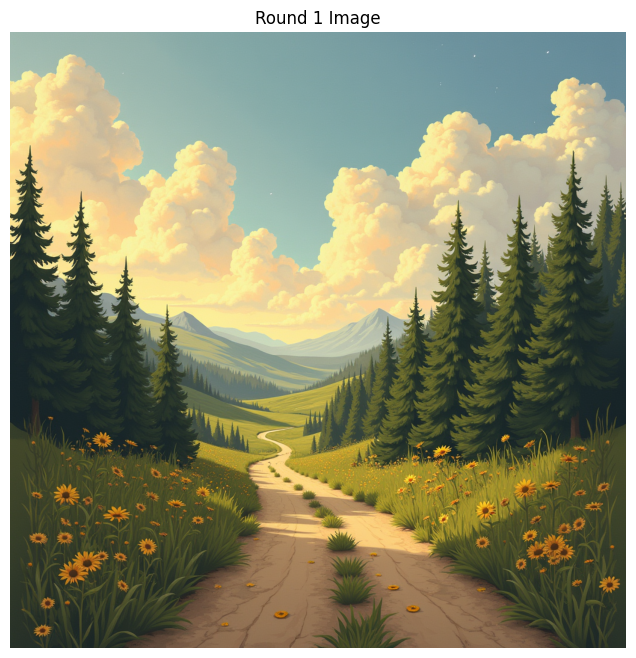

Description: The image depicts a serene and picturesque landscape. In the foreground, there is a winding dirt path that meanders through a lush green field dotted with yellow flowers. The path is flanked by tall grass and wildflowers, creating a natural corridor that leads the viewer's eye deeper into the scene.

On either side of the path, there are clusters of tall, evergreen trees, their dark green foliage contrasting with the vibrant colors of the flowers and grass. These trees frame the path and add a sense of depth and enclosure to the scene.

In the middle ground, the landscape opens up to reveal rolling hills that stretch towards the horizon. These hills are covered in a mix of greenery and patches of trees, giving the impression of a vast, natural expanse. The hills gradually rise in the distance, leading to a range of mountains that form a majestic backdrop.

The mountains are depicted with a soft, painterly quality, their peaks gradually fading into the sky. The sky itself i

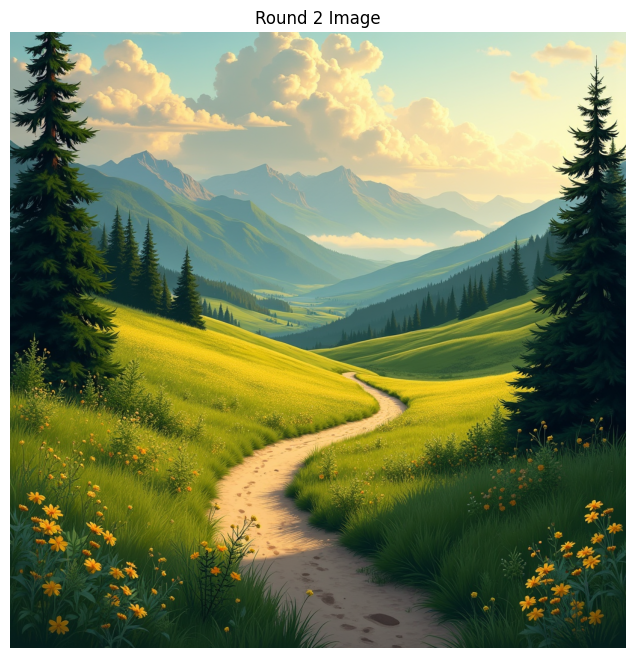

Description: The image depicts a serene and picturesque landscape. In the foreground, there is a winding dirt path that meanders through a lush, green field dotted with yellow wildflowers. The path appears well-trodden, suggesting it is frequently used. To the left and right of the path, tall pine trees stand sentinel, their dark green needles contrasting with the vibrant grass.

The field extends back towards a series of rolling hills, which are also covered in greenery. These hills gradually rise to meet a range of majestic mountains in the background. The mountains are layered, with each successive range becoming lighter and more hazy, creating a sense of depth and distance.

Above, the sky is a beautiful expanse of blue, dotted with fluffy white clouds. The lighting suggests it is either early morning or late afternoon, with the sun casting a warm, golden glow over the entire scene. The overall atmosphere is one of tranquility and natural beauty, inviting the viewer to imagine taki

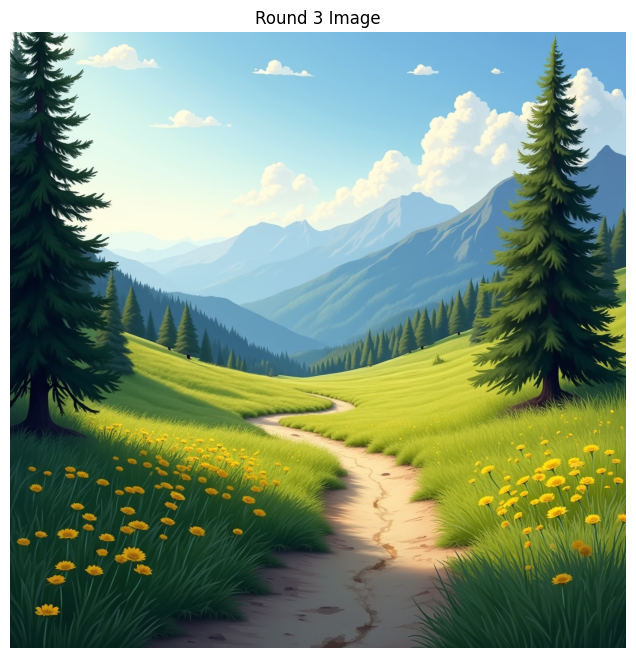

Description: The image depicts a serene and picturesque landscape. It features a winding dirt path that meanders through a lush green meadow. The meadow is dotted with vibrant yellow flowers, adding a touch of color to the scene. Tall evergreen trees flank the path on either side, their dense foliage providing a natural frame for the view. In the distance, majestic mountains rise against a clear blue sky, with fluffy white clouds scattered across it. The overall scene is one of tranquility and natural beauty, suggesting a peaceful day in a mountainous region.


In [17]:
import os

from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"))


game = BrokenTelephone(client=client)

# Start the game
game.play_game(
    n_rounds=3,
    starting_prompt="We chose the road and we will follow where it leads.",
    save_path="broken_telephone_results"
)

# Visualize the evolution
game.visualize_history()

## Task 3\*. A very simple GenAI-powered service

If you used LLMs to do the previous task, you probably understand how much powerful LLMs are as coding assistants. So, we challenge you to try leveraging their power to turn the code you've created in **Task 2** into a full-fledged web service!

For now, create a simple app that you can launch in colab and call from another colab. In the end of week 1, we'll launch a cloud-based chat service, and you'll learn about some best practices of doing this. For now, cloud deployment may prove tough, if you haven't done this before.

Please be ready that the very first attempt may fail, the service refusing to start, crashing, and flooding you with outlandish errors. Take it easy and share the mistakes with the LLM in the same chat. After several iterations you should be fine! [Let Andrej Karpathy motivate you!](https://x.com/karpathy/status/1886192184808149383)

For the author of this notebook, it took about 12 iterations of "vibe coding" (that is, coding without thinking much about what's happening in the code) to get a working server.